In [192]:
#KÜTÜPHANELER
import os
import random
import shutil
import csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split

In [11]:
#ÇALIŞMA DİZİNİNİN AYARLANMASI VE HATA KONTROLÜ
try:
    os.chdir(r"C:\Users\Eda EROL\OneDrive\veriset")
    print("Yeni Dizin:", os.getcwd())
except FileNotFoundError:
    print("HATA: Belirtilen dizin bulunamadı.")

Yeni Dizin: C:\Users\Eda EROL\OneDrive\veriset


In [12]:
#GÖRÜNTÜ DOSYALARININ TEK BİR KLASÖRDE BİRLEŞTİRİLMESİ
src_dirs = ["HAM10000_images_part_1", "HAM10000_images_part_2"]
dst_dir = "all_images"
os.makedirs(dst_dir, exist_ok=True)

In [13]:
for folder in src_dirs:
    folder_path = os.path.join(os.getcwd(), folder)
    for file in os.listdir(folder_path):
        src_path = os.path.join(folder_path, file)
        dst_path = os.path.join(dst_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

In [14]:
print(f"Tüm görüntüler '{dst_dir}' klasöründe toplandı. Toplam: {len(os.listdir(dst_dir))} dosya")

Tüm görüntüler 'all_images' klasöründe toplandı. Toplam: 10015 dosya


In [15]:
#HAM10000 METADATA BİLGİLERİNİN YÜKLENMESİ
metadata_file = "HAM10000_metadata.csv"
metadata = []

In [16]:
with open(metadata_file, newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        metadata.append(row)

In [17]:
print(f"Metadata yüklendi. Toplam satır: {len(metadata)}")

Metadata yüklendi. Toplam satır: 10015


In [20]:
#METADATA'YI DATAFRAME'E ÇEVİRME
df = pd.read_csv(r"C:\Users\Eda EROL\OneDrive\veriset\HAM10000_metadata.csv")

In [21]:
print("Toplam veri sayısı:", len(df))

Toplam veri sayısı: 10015


In [28]:
#METADATA ÖN İNCELEME(İLK 5 SATIR)
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [29]:
#SINIF ETİKETLERİNİN SAYISAL DAĞILIMI
class_counts = df["dx"].value_counts()

In [30]:
print(class_counts)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [196]:
#LABELLARI SAYISAL OLARAK AL
labels = np.array([item['dx'].upper() for item in metadata]) 

In [197]:
#LABELLARI SAYIYA ÇEVİR
label_map = {"AKIEC":0, "BCC":1, "BKL":2, "DF":3, "MEL":4, "NV":5, "VASC":6}
numeric_labels = np.array([label_map[l] for l in labels])

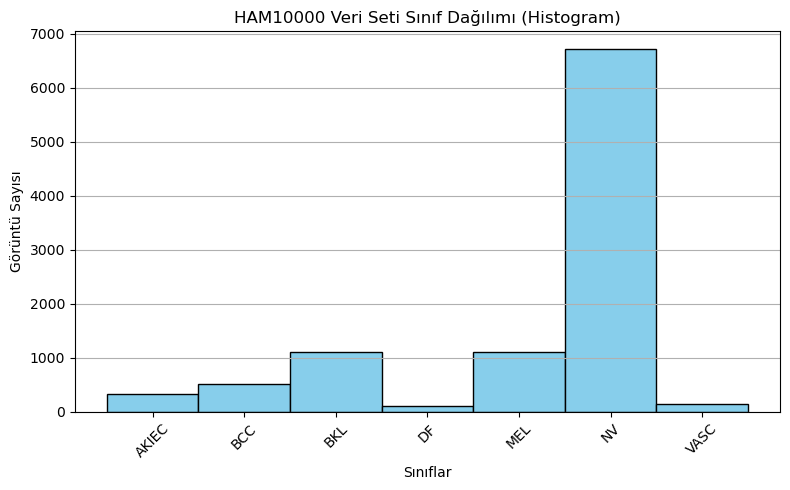

In [198]:
#HAM10000 VERİ SETİ SINIF DAĞILIMI(HİSTOGRAM)
plt.figure(figsize=(8,5))
plt.hist(numeric_labels, bins=np.arange(len(label_map)+1)-0.5, color='skyblue', edgecolor='black')
plt.xticks(range(len(label_map)), label_map.keys(), rotation=45)
plt.xlabel("Sınıflar")
plt.ylabel("Görüntü Sayısı")
plt.title("HAM10000 Veri Seti Sınıf Dağılımı (Histogram)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

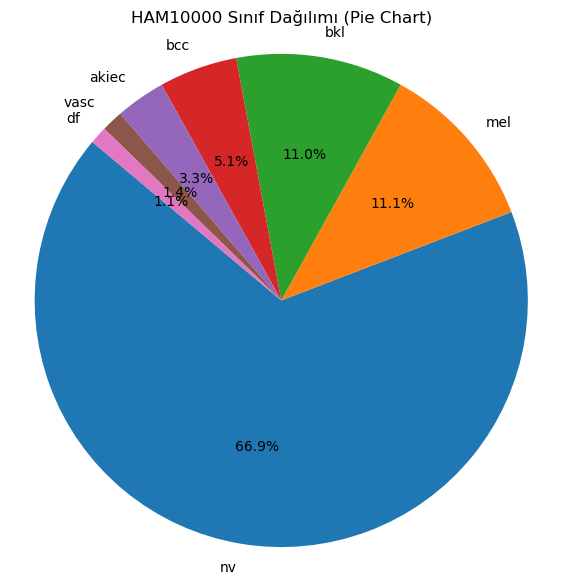

In [199]:
#HAM10000 VERİ SETİ SINIF DAĞILIMI(PIE CHART)
plt.figure(figsize=(7,7))
plt.pie(
    class_counts.values,
    labels=class_counts.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("HAM10000 Sınıf Dağılımı (Pie Chart)")
plt.axis("equal")
plt.show()

In [37]:
#MODEL İÇİN KULLANILABİLİR VERİ LİSTESİ OLUŞTURMA
label_map = {"akiec":0, "bcc":1, "bkl":2, "df":3, "mel":4, "nv":5, "vasc":6}
data_list = []

In [38]:
for item in metadata:
    img_id = item["image_id"]
    label = label_map[item["dx"]]
    img_path = os.path.join(dst_dir, img_id + ".jpg")
    if os.path.exists(img_path):
        data_list.append((img_path, label))

In [39]:
print(f"Toplam kullanılabilir veri: {len(data_list)}")

Toplam kullanılabilir veri: 10015


In [46]:
#STRATIFIED SPLIT(TRAIN/VAL/TEST)
#DATA&LABEL LİSTELERİNİ AYIR
X = [x[0] for x in data_list]  #görüntü yolları
y = [x[1] for x in data_list]  #etiketler

In [47]:
#TRAIN+TEMP(VAL+TEST)AYRIŞTIR
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [48]:
#TEMP'İ VAL VE TEST OLARAK AYRIŞTIR
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [49]:
#TRAIN/VAL/TEST LİSTELERİNİ OLUŞTUR
train_list = list(zip(X_train, y_train))
val_list = list(zip(X_val, y_val))
test_list = list(zip(X_test, y_test))

In [50]:
print(f"Train: {len(train_list)}, Val: {len(val_list)}, Test: {len(test_list)}")

Train: 7010, Val: 1502, Test: 1503


In [51]:
#MODEL GİRİŞ GÖRÜNTÜ BOYUTU (300x300)
IMG_SIZE = 300  #EfficientNet-B3 için

In [52]:
#TRAIN TRANSFORMS
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [53]:
#VAL/TEST TRANSFORMS
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [54]:
#DATASET SINIFI:GÖRÜNTÜ YÜKLEME VE ÖN İŞLEME
class SkinDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    def __len__(self):
        return len(self.data_list)
    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [55]:
#TRAIN/VAL/TEST DATASET NESNELERİNİN OLUŞTURULMASI
train_dataset = SkinDataset(train_list, transform=train_transform)
val_dataset = SkinDataset(val_list, transform=val_test_transform)
test_dataset = SkinDataset(test_list, transform=val_test_transform)

In [56]:
#TRAIN/VAL/TEST DATALOADER OLUŞTURMA
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [57]:
print("DataLoader hazır!")

DataLoader hazır!


In [62]:
#DEVICE AYARI(CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
print("Çalıştırılan device:", device)

Çalıştırılan device: cuda


In [64]:
#MODEL – EfficientNet-B3
weights = EfficientNet_B3_Weights.IMAGENET1K_V1 
model = efficientnet_b3(weights=weights)

In [65]:
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 7)

In [66]:
model = model.to(device)

In [67]:
#KAYIP FONKSİYONU,OPTİMİZATÖR VE EARLY STOPPING PARAMETRELERİ
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop_patience = 5

In [68]:
#EĞİTİM İÇİN PARAMETRELER VE KAYIP/DOĞRULAMA METRİKLERİNİN TAKİBİ
num_epochs = 15
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
best_val_acc = 0
patience_counter = 0

In [69]:
#TEMEL EĞİTİM VE DOĞRULAMA ADIMLARI, KAYIP VE DOĞRULUK TAKİBİ
for epoch in range(num_epochs):
    #TRAIN
    model.train()
    running_loss, correct, total = 0,0,0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)  

    #VALIDATION
    model.eval()
    val_running_loss, val_correct, val_total = 0,0,0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    #EARLY STOPPING
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_base.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping tetiklendi!")
            break


Epoch 1/15 | Train Loss: 0.7719 | Val Loss: 0.5250 | Train Acc: 0.7385 | Val Acc: 0.8056
Epoch 2/15 | Train Loss: 0.4788 | Val Loss: 0.4066 | Train Acc: 0.8318 | Val Acc: 0.8535
Epoch 3/15 | Train Loss: 0.3632 | Val Loss: 0.3669 | Train Acc: 0.8662 | Val Acc: 0.8755
Epoch 4/15 | Train Loss: 0.2826 | Val Loss: 0.3569 | Train Acc: 0.8966 | Val Acc: 0.8688
Epoch 5/15 | Train Loss: 0.2085 | Val Loss: 0.3352 | Train Acc: 0.9290 | Val Acc: 0.8875
Epoch 6/15 | Train Loss: 0.1613 | Val Loss: 0.3117 | Train Acc: 0.9411 | Val Acc: 0.9041
Epoch 7/15 | Train Loss: 0.1285 | Val Loss: 0.3826 | Train Acc: 0.9561 | Val Acc: 0.9008
Epoch 8/15 | Train Loss: 0.1135 | Val Loss: 0.3500 | Train Acc: 0.9615 | Val Acc: 0.8995
Epoch 9/15 | Train Loss: 0.0849 | Val Loss: 0.4157 | Train Acc: 0.9695 | Val Acc: 0.8842
Epoch 10/15 | Train Loss: 0.0861 | Val Loss: 0.3369 | Train Acc: 0.9709 | Val Acc: 0.8961
Epoch 11/15 | Train Loss: 0.0661 | Val Loss: 0.3726 | Train Acc: 0.9789 | Val Acc: 0.8988
Early stopping teti

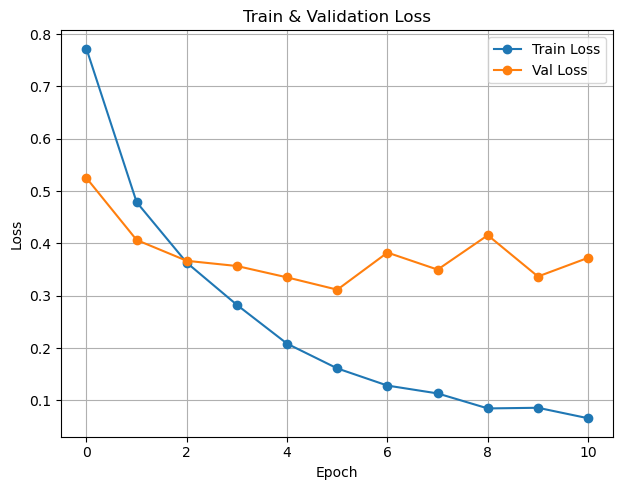

In [74]:
#TRAIN VE VALIDATION LOSS GRAFİĞİ
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

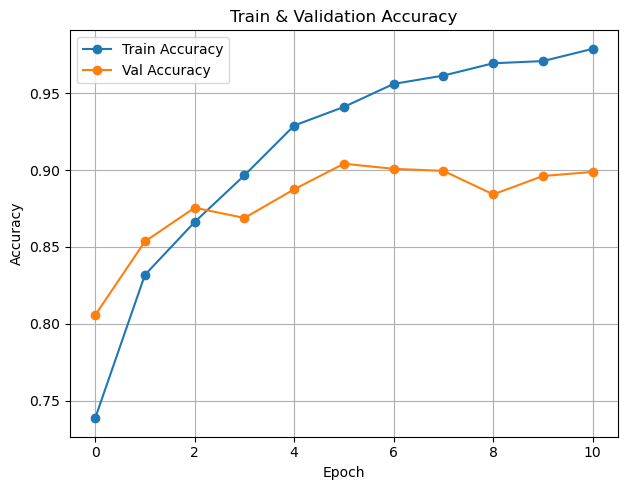

In [75]:
#TRAIN VE VALIDATION ACCURACY GRAFİĞİ
plt.figure(figsize=(12,5))
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
#TEST VERİ SETİ ÜZERİNDE DOĞRULUK (ACCURACY) HESAPLAMA
test_accuracy = correct / total

In [79]:
print(f" Test Accuracy: {test_accuracy:.4f}")

 Test Accuracy: 0.9789


In [85]:
#FINE-TUNING İÇİN FEATURE KATMANLARININ GRADIENT’LERİNİ AÇ
for param in model.features.parameters():
    param.requires_grad = True

In [86]:
#FINE-TUNING İÇİN OPTİMİZER TANIMLAMA
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [87]:
#FINE-TUNING EĞİTİMİ VE DOĞRULAMA METRİKLERİNİ TUTMAK İÇİN LİSTELERİ OLUŞTURMA
ft_train_losses, ft_val_losses, ft_train_accuracies, ft_val_accuracies = [], [], [], []

In [88]:
#FINE-TUNING EPOCH SAYISI,EN İYİ VALIDATION ACC VE PATIENCE SAYACINI TANIMLAMA
num_epochs_ft = 5
best_val_acc = 0
patience_counter = 0

In [89]:
#FINE-TUNING EĞİTİM VE DOĞRULAMA DÖNGÜSÜ (EARLY STOPPING İLE)
for epoch in range(num_epochs_ft):
    #TRAIN
    model.train()
    running_loss, correct, total = 0,0,0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    ft_train_losses.append(train_loss)
    ft_train_accuracies.append(train_acc)  

    #VALIDATION
    model.eval()
    val_running_loss, val_correct, val_total = 0,0,0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs,1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    ft_val_losses.append(val_loss)
    ft_val_accuracies.append(val_acc)

    print(f"FT Epoch {epoch+1}/{num_epochs_ft} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    #EARLY STOPPING
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_ft.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping tetiklendi!")
            break

FT Epoch 1/5 | Train Loss: 0.0500 | Val Loss: 0.3076 | Train Acc: 0.9833 | Val Acc: 0.9015
FT Epoch 2/5 | Train Loss: 0.0389 | Val Loss: 0.3133 | Train Acc: 0.9874 | Val Acc: 0.9108
FT Epoch 3/5 | Train Loss: 0.0357 | Val Loss: 0.3176 | Train Acc: 0.9896 | Val Acc: 0.9134
FT Epoch 4/5 | Train Loss: 0.0276 | Val Loss: 0.3117 | Train Acc: 0.9914 | Val Acc: 0.9095
FT Epoch 5/5 | Train Loss: 0.0250 | Val Loss: 0.3315 | Train Acc: 0.9933 | Val Acc: 0.9115


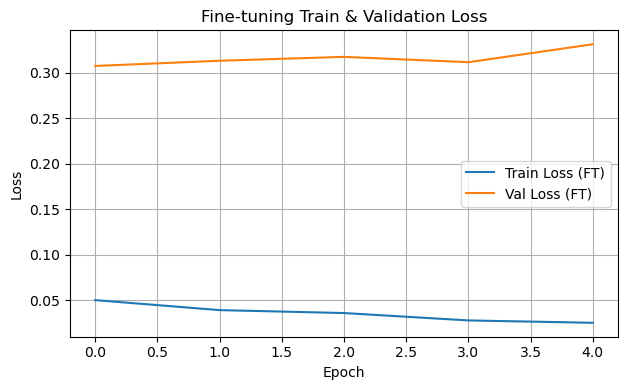

In [94]:
#FINE-TUNING TRAIN&VALIDATION LOSS GRAFİĞİ
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ft_train_losses, label='Train Loss (FT)')
plt.plot(ft_val_losses, label='Val Loss (FT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-tuning Train & Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

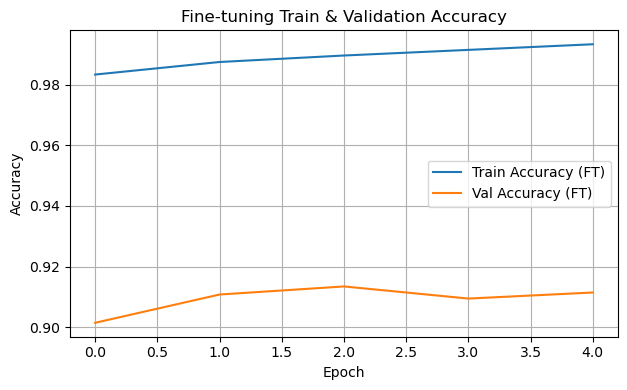

In [95]:
#FINE-TUNING TRAIN&VALIDATION ACCURACY GRAFİĞİ
plt.figure(figsize=(12,4))
plt.subplot(1,2,2)
plt.plot(ft_train_accuracies, label='Train Accuracy (FT)')
plt.plot(ft_val_accuracies, label='Val Accuracy (FT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Train & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
#FINE-TUNING TEST SETİ ÜZERİNDE DOĞRULUK HESAPLAMA
model.eval()
all_preds, all_labels = [], []


In [97]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [99]:
test_correct = np.sum(np.array(all_preds) == np.array(all_labels))
test_total = len(all_labels)
test_acc = test_correct / test_total

In [100]:
print(f"[Fine-Tuning] Test Accuracy: {test_acc:.4f}")

[Fine-Tuning] Test Accuracy: 0.8962


In [118]:
#FINE-TUNED MODELİ YÜKLEME VE TEST METRİKLERİ İÇİN LİSTELERİ HAZIRLAMA
model.load_state_dict(torch.load("best_model_ft.pth"))
model.eval()
all_preds, all_labels, all_probs = [], [], []

In [119]:
#TEST VERİSİ ÜZERİNDEN TAHMİNLERİ,OLASILIKLARI VE GERÇEK ETİKETLERİ TOPLAMA
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

In [120]:
#CONFUSION MATRIX HESAPLAMA
cm = confusion_matrix(all_labels, all_preds)

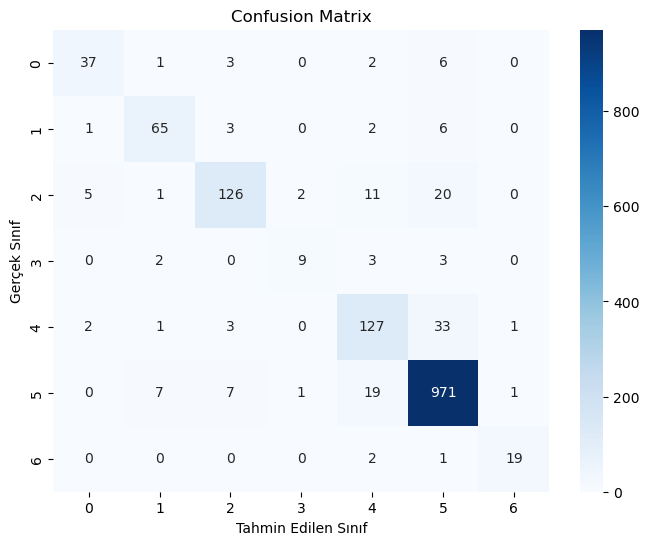

In [121]:
#CONFUSION MATRIX GÖRSELLEŞTİRME
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

In [122]:
#CONFUSION MATRIX YAZDIRMA
print(cm)

[[ 37   1   3   0   2   6   0]
 [  1  65   3   0   2   6   0]
 [  5   1 126   2  11  20   0]
 [  0   2   0   9   3   3   0]
 [  2   1   3   0 127  33   1]
 [  0   7   7   1  19 971   1]
 [  0   0   0   0   2   1  19]]


In [123]:
#SINIFLANDIRMA RAPORUNU YAZDIRMA
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79        49
           1       0.84      0.84      0.84        77
           2       0.89      0.76      0.82       165
           3       0.75      0.53      0.62        17
           4       0.77      0.76      0.76       167
           5       0.93      0.97      0.95      1006
           6       0.90      0.86      0.88        22

    accuracy                           0.90      1503
   macro avg       0.84      0.78      0.81      1503
weighted avg       0.90      0.90      0.90      1503



In [127]:
#MULTİSINIF ROC-AUC HESAPLAMALARI İÇİN DEĞİŞKENLERİ HAZIRLAMA
all_labels_bin = label_binarize(all_labels, classes=[0,1,2,3,4,5,6])
fpr, tpr, roc_auc = {}, {}, {}

In [128]:
#MULTİSINIF ROC-EĞRİLERİNİ HESAPLAMA
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:,i], np.array(all_probs)[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


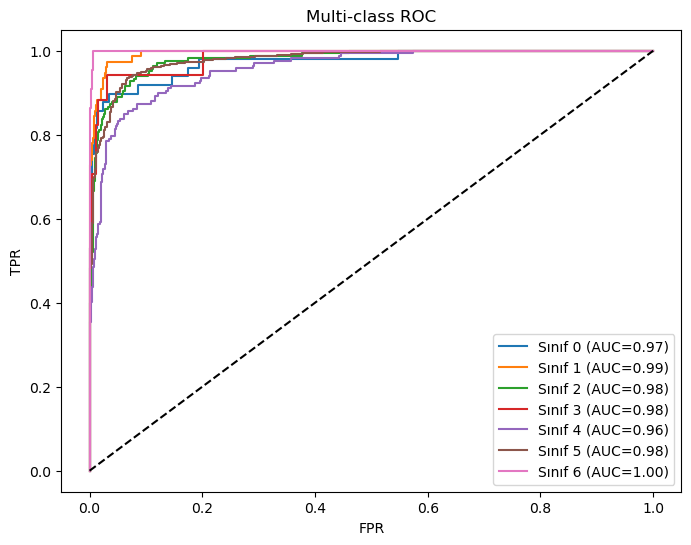

In [129]:
#MULTİSINIF ROC EĞRİLERİNİ GÖRSELLEŞTİRME
plt.figure(figsize=(8,6))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f"Sınıf {i} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Multi-class ROC')
plt.legend()
plt.show()

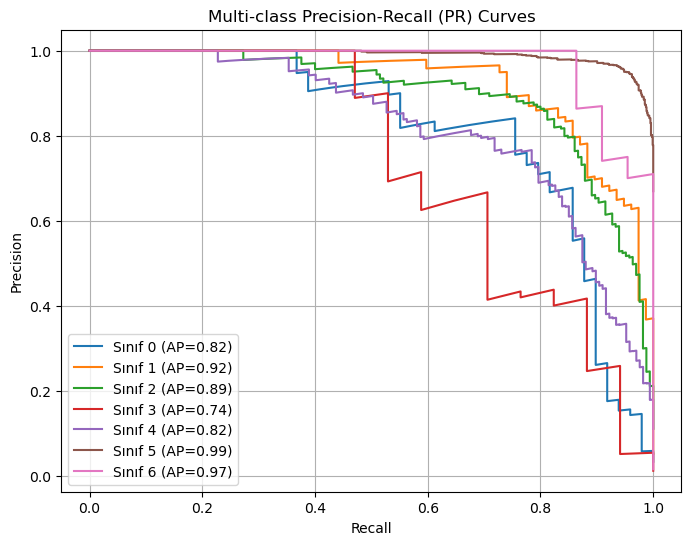

In [133]:
#MULTI-CLASS PRECISION-RECALL(PR) EĞRİLERİ
plt.figure(figsize=(8,6))

#HER SINIF İÇİN PRECISION-RECALL(PR) HESABI VE ÇİZİMİ
for i in range(7):
    precision, recall, _ = precision_recall_curve(all_labels_bin[:,i], np.array(all_probs)[:,i])
    ap = average_precision_score(all_labels_bin[:,i], np.array(all_probs)[:,i])
    plt.plot(recall, precision, label=f"Sınıf {i} (AP={ap:.2f})")
#MULTI-CLASS PRECISION-RECALL(PR) EĞRİLERİNİN GÖRSELLEŞTİRİLMESİ
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall (PR) Curves")
plt.legend()
plt.grid(True)
plt.show()


In [152]:
#KANSER VE BENIGN SINIFLARINI TANIMLAMA
cancer_classes = [0,1,3,4]   # Malign/pre-cancer
benign_classes = [2,5,6]     # Benign

In [154]:
#TEST ETİKETLERİNİ BINARY HALİNE GETİRME(CANCER&BENIGN)
all_labels_cancer = [1 if l in cancer_classes else 0 for l in all_labels]
all_labels_benign = [1 if l in benign_classes else 0 for l in all_labels]


In [155]:
#TAHMİN OLASILIKLARINI BİRLEŞTİRME(CANCER&BENIGN)
all_probs_cancer = [sum([p[i] for i in cancer_classes]) for p in all_probs]
all_probs_benign = [sum([p[i] for i in benign_classes]) for p in all_probs]

In [156]:
#KANSER VE BENIGN SINIFLARI İÇİN ROC-AUC HESAPLAMA
fpr_c, tpr_c, _ = roc_curve(all_labels_cancer, all_probs_cancer)
roc_auc_c = auc(fpr_c, tpr_c)

fpr_b, tpr_b, _ = roc_curve(all_labels_benign, all_probs_benign)
roc_auc_b = auc(fpr_b, tpr_b)


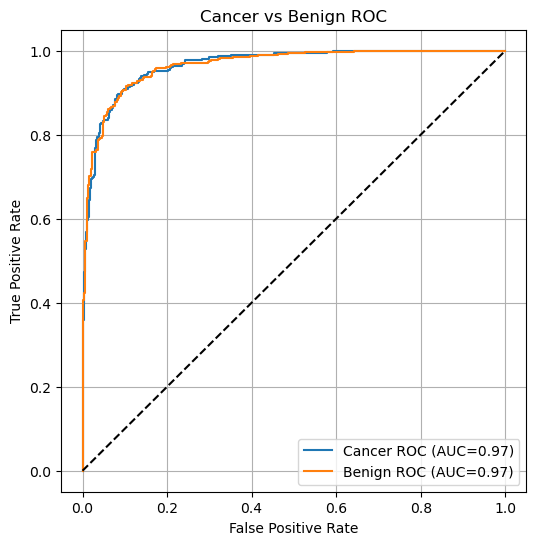

In [157]:
#KANSER VE BENIGN SINIFLARI İÇİN ROC GRAFİĞİ
plt.figure(figsize=(6,6))
plt.plot(fpr_c, tpr_c, label=f'Cancer ROC (AUC={roc_auc_c:.2f})')
plt.plot(fpr_b, tpr_b, label=f'Benign ROC (AUC={roc_auc_b:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cancer vs Benign ROC')
plt.legend()
plt.grid(True)
plt.show()

In [161]:
#KANSER SINIFI İÇİN PRECISION-RECALL VE AP HESAPLAMA
precision_c, recall_c, _ = precision_recall_curve(all_labels_cancer, all_probs_cancer)
pr_auc_c = average_precision_score(all_labels_cancer, all_probs_cancer)

In [162]:
#BENIGN SINIFI İÇİN PRECISION-RECALL VE AP HESAPLAMA
precision_b, recall_b, _ = precision_recall_curve(all_labels_benign, all_probs_benign)
pr_auc_b = average_precision_score(all_labels_benign, all_probs_benign)


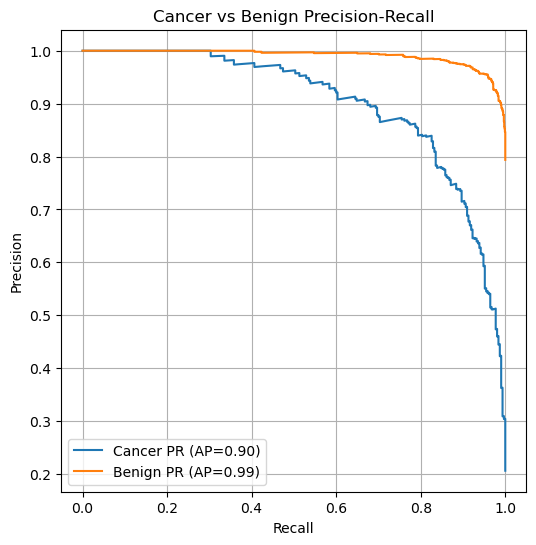

In [163]:
#KANSER VE BENIGN SINIFLARI İÇİN PRECISION-RECALL(PR) GRAFİĞİ
plt.figure(figsize=(6,6))
plt.plot(recall_c, precision_c, label=f'Cancer PR (AP={pr_auc_c:.2f})')
plt.plot(recall_b, precision_b, label=f'Benign PR (AP={pr_auc_b:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Cancer vs Benign Precision-Recall')
plt.legend()
plt.grid(True)
plt.show()


In [180]:
#KLİNİK TAHMİN (BENIGN/PRE-CANCER/CANCER)
clinical_pred = []
for p in all_preds:
    if p in [2,5,6]:
        clinical_pred.append("Benign")
    elif p in [0,1,3]:
        clinical_pred.append("Pre-cancer")
    else:
        clinical_pred.append("Cancer")

In [181]:
#KLİNİK GERÇEK ETİKETLER (BENIGN/PRE-CANCER/CANCER)
clinical_labels = []
for l in all_labels:
    if l in [2,5,6]:
        clinical_labels.append("Benign")
    elif l in [0,1,3]:
        clinical_labels.append("Pre-cancer")
    else:
        clinical_labels.append("Cancer")

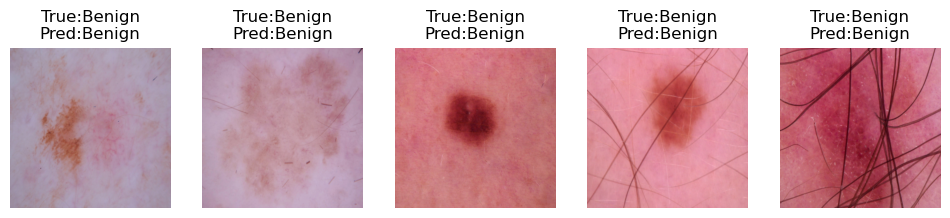

In [182]:
#ÖRNEK TEST GÖRÜNTÜLERİ VE KLİNİK ETİKETLERİ İLE TAHMİNLERİN GÖRSELLEŞTİRİLMESİ
plt.figure(figsize=(12,6))
for i in range(5):
    img, label = test_dataset[i]
    plt.subplot(1,5,i+1)
    plt.imshow(img.permute(1,2,0)*0.5 +0.5)
    plt.title(f"True:{clinical_labels[i]}\nPred:{clinical_pred[i]}")
    plt.axis('off')
plt.show()

In [183]:
#GRAD-CAM SINIFI(Modelin seçilen katmanı için sınıf aktivasyon haritalarını üretir)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[0, class_idx]
        loss.backward()

        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1,2), keepdim=True)
        cam = (weights * activations).sum(dim=0)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.cpu().numpy()
        return cam

In [184]:
# GRAD-CAM HEATMAP’İNİ ORİJİNAL GÖRÜNTÜ ÜZERİNE BİNDİRME FONKSİYONU
def overlay_cam(img, cam, alpha=0.5, colormap=cv2.COLORMAP_JET):
    cam = cv2.resize(cam, (img.size[0], img.size[1]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    img_np = np.array(img)
    overlayed = np.uint8(heatmap*alpha + img_np*(1-alpha))
    return overlayed

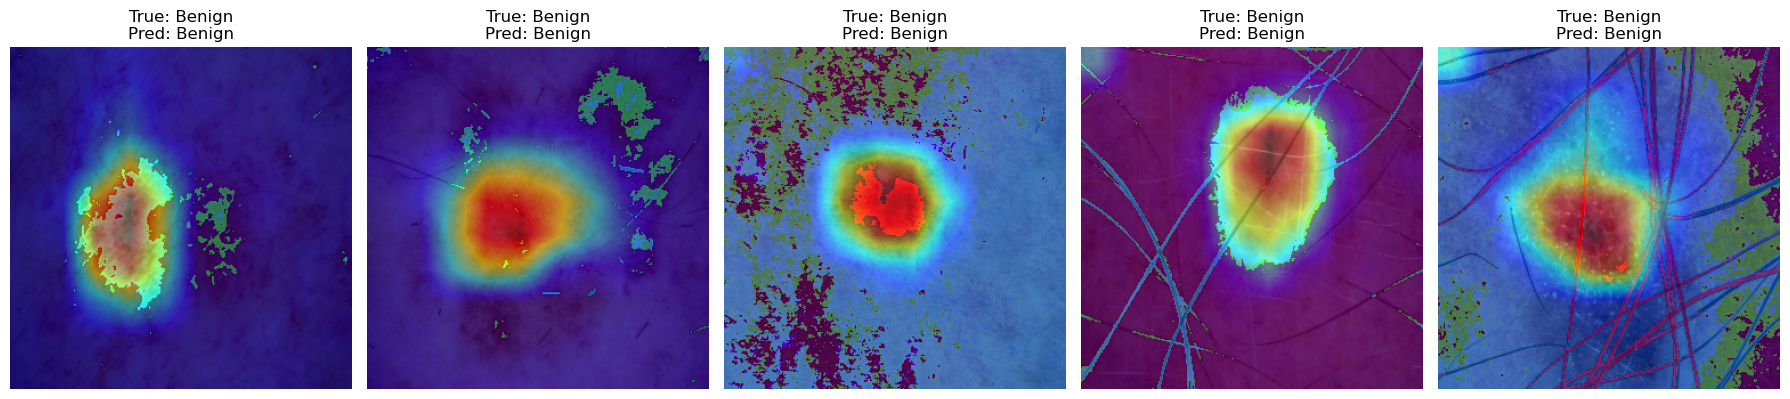

In [185]:
#ÖRNEK TEST GÖRÜNTÜLERİ ÜZERİNE GRAD-CAM OVERLAY GÖRSELLEŞTİRME
plt.figure(figsize=(18,6))

target_layer = model.features[-1]  #EfficientNet-B3 son conv bloğu
grad_cam = GradCAM(model, target_layer)

#TESTTEN 5 GÖRÜNTÜ İÇİN VERİ HAZIRLAMA
for i in range(5):
    img_tensor, label_idx = test_dataset[i]
    img_input = img_tensor.unsqueeze(0).to(device)

    #GRAD-CAM İLE SINIF AKTİVASYON HARİTASINI HESAPLAMA
    cam = grad_cam.generate_cam(img_input)

    #GRAD-CAM HEATMAP'İNİ GÖRÜNTÜ ÜZERİNE UYGULAMA(OVERLAY)
    img_pil = transforms.ToPILImage()(img_tensor)
    overlayed_img = overlay_cam(img_pil, cam)

    #GÖRSELLEŞTİRME
    plt.subplot(1,5,i+1)
    plt.imshow(overlayed_img)
    plt.title(f"True: {clinical_labels[i]}\nPred: {clinical_pred[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [189]:
#GERÇEK VE KAÇIRILAN KANSER SAYISINI HESAPLAMA
total_cancer = sum([1 for l in clinical_labels if l == "Cancer"])
missed_cancer = sum([1 for pl, tl in zip(clinical_pred, clinical_labels) if pl != "Cancer" and tl == "Cancer"])

In [190]:
#KANSER İÇİN FALSE NEGATIVE ORANI HESAPLAMA
fn_rate = missed_cancer / total_cancer

In [191]:
#KANSER İÇİN ÖZET BİLGİLERİ YAZDIRMA
print(f"Toplam Gerçekte Kanser: {total_cancer}")
print(f"Kaçırılan Kanser Sayısı: {missed_cancer}")
print(f"Cancer False Negative Rate: {fn_rate:.2%}")

Toplam Gerçekte Kanser: 167
Kaçırılan Kanser Sayısı: 40
Cancer False Negative Rate: 23.95%
